In [1]:
#Import Modules

#GPyOpt - Cases are important, for some reason
import GPyOpt
from GPyOpt.methods import BayesianOptimization

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import multivariate_normal


In [21]:
#Define the objective function
def obj_func(x):
    out = x**4 + 2*x**3 -12*x**2 - 2*x + 6
    return(out)

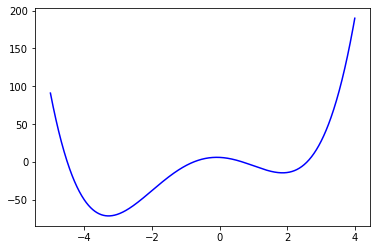

In [22]:
#Plot the function 
x = pd.Series(np.linspace(-5,4,1000))
f_x = pd.Series.apply(x, obj_func)

plt.plot(x, f_x, 'b-')
plt.show()

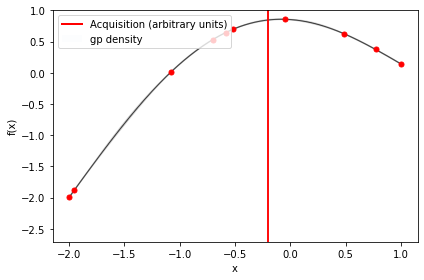

In [7]:
# domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (-2,1)}]


# myBopt_1d = BayesianOptimization(f=obj_func, domain=domain)
# myBopt_1d.run_optimization(max_iter=5)
# myBopt_1d.plot_acquisition()


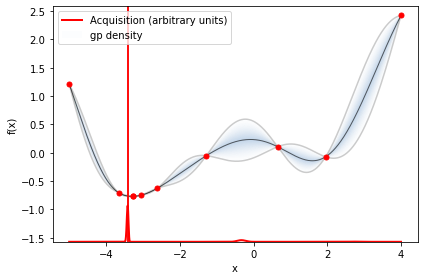

In [23]:

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (-5,4)}]


myBopt_1d = BayesianOptimization(f=obj_func, domain=domain)
myBopt_1d.run_optimization(max_iter=5)
myBopt_1d.plot_acquisition()

In [24]:
ins = myBopt_1d.get_evaluations()[1].flatten()
outs = myBopt_1d.get_evaluations()[0].flatten()
evals = pd.DataFrame(ins, outs)
print(evals.sort_index())


                    0
-5.000000   91.000000
-3.655661  -66.169743
-3.276342  -71.371854
-3.272680  -71.370097
-3.038695  -69.582603
-2.606274  -59.566226
-1.278216  -12.556972
 0.652354    0.324845
 1.954890  -14.222736
 4.000000  190.000000


In [25]:
print("The minumum value obtained by the function was %.4f (x = %.4f)" % (myBopt_1d.fx_opt, myBopt_1d.x_opt))

The minumum value obtained by the function was -71.3719 (x = -3.2763)


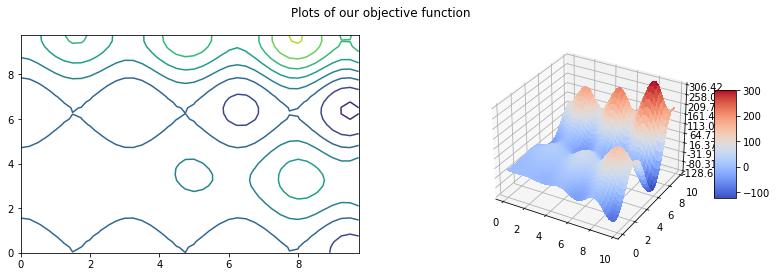

In [11]:
#2-Dimensional Example

def obj_func_2d(x,y):
    return((x**2 + y**2)*(np.sin(x)**2 - np.cos(y)))


fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Plots of our objective function')

# Make data.
X = np.arange(0, 10, 0.25)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = obj_func_2d(X,Y)



# First subplot
ax = fig.add_subplot(1, 2, 1)
ax.contour(X,Y,Z)

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


Value of (x,y) that minimises the objective:[9.51793694 6.39890722]
Minimum value of the objective: -129.51911679544023


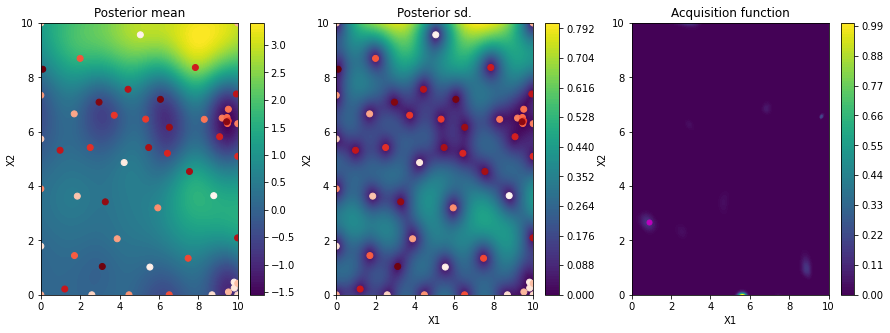

In [12]:
def objfunc2d(x):
    """
    x is a 2 dimensional vector.
    """ 
    x1 = x[:, 0]
    x2 = x[:, 1]
    return((x1**2 + x2**2)*(np.sin(x1)**2 - np.cos(x2)))

bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0,10)}]
maxiter = 50

myBopt_2d = GPyOpt.methods.BayesianOptimization(objfunc2d, domain=bounds2d)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()



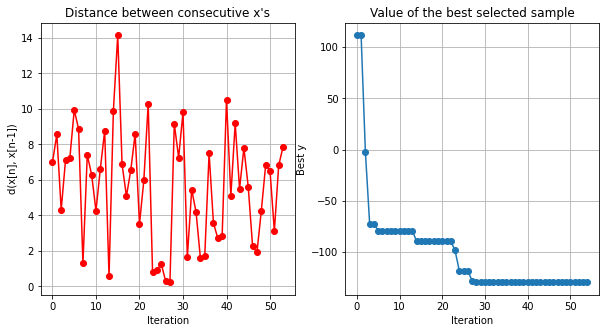

In [13]:
#Plot some more characteristics:

myBopt_2d.plot_convergence() #Can clearly see it spends quite some time exploring the best small section 
#which it thinks is the best space

In [14]:
def stochastic_obj_func_2d_const(x):
    #Construct our normal parameters:
    
    mu1,mu2,Sig_diag1,Sig_diag2,Sig_Cross = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4]
    
    mu = np.array([mu1[0], mu2[0]]).flatten()
    Sigma = np.array([[Sig_diag1[0], Sig_Cross[0]], [Sig_Cross[0], Sig_diag2[0]]]) #Cov Matrix must be symmetric so 
    
    sample = multivariate_normal(mu, Sigma, check_valid = 'raise')
    
    #Now run the deterministic objective function
    return(obj_func_2d(sample[0], sample[1]))


In [15]:
#Now lets set up the Bayesian Optimisation:
#Guide on how to do it with constraints: https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/devel/manual/GPyOpt_constrained_optimization.ipynb

bounds = [{'name': 'mu_1', 'type': 'continuous', 'domain': (0,10)},
        {'name': 'mu_2', 'type': 'continuous', 'domain': (0,10)},
         {'name': 'Sig_diag_1', 'type': 'continuous', 'domain': (0,5)},
         {'name': 'Sig_diag_2', 'type': 'continuous', 'domain': (0,5)},
         {'name': 'Sig_Cross', 'type': 'continuous', 'domain': (-5,5)}]

constraints = [{'name': 'constr_1', 'constraint': '-x[:,2]'},
              {'name': 'constr_2', 'constraint': '-x[:,3]'},
              {'name': 'constr_3', 'constraint': '-x[:,2]*x[:,3] + x[:,4]**2'}]

#Above constraints ensure our 2x2 covariance matrix will be symmetric positive definite 
#The expression corresponding to 'constraint' is an inequality that is less than zero - i.e. x[:,2] > 0 etc.

In [16]:
#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(stochastic_obj_func_2d_const)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [17]:
# Now create BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

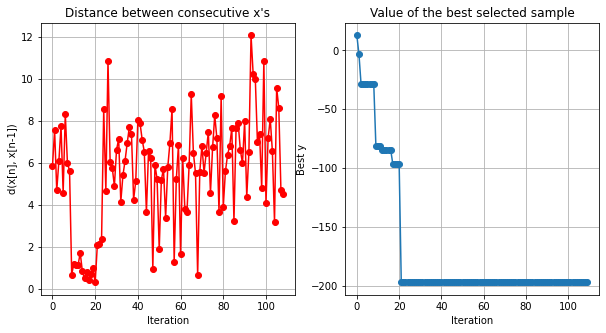

In [18]:
# --- Stop conditions
max_time  = None 
max_iter  = 100
tolerance = 1e-8     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=False) 
bo.plot_convergence()

In [19]:
print(bo.x_opt)
print(bo.fx_opt)

[9.81619017 6.30117394 4.38452854 0.02563664 0.21667101]
-197.15874000712648


In [20]:
print(bo.X[0:5]) #The first five evaluations

[[ 1.5806302   5.48587702  1.88421158  2.1344906   1.39312469]
 [ 5.02060404  1.809752    4.24752461  2.66804706  3.09601026]
 [ 7.45744799  8.14072328  2.06521654  1.36351232  0.9723675 ]
 [ 8.24903344  6.80864012  4.51955411  2.30222067 -2.56811839]
 [ 9.42041866  5.24196656  2.30335753  4.28704898  2.35874924]]
